<center><b> 1D time-dependent Frantz Nodvik equations </b></center>

<br> du1/dt + gamma*K*u1*u2 = 0           u1 = Delta = # density of excited states 
<br> du2/dt + c*du2/dx - K*u1*u2 = 0      u2 = n_ph  = # density of photons
<br>                                      c = speed of light
<br>                                      K = sigma * c
<br> IC:  TBD...
<br> BC:  TBD...
<br> This code is distributed under the Apache License, Version 2.0, January 2004.
<br> Copyright (c) 2020 RadiaSoft LLC, All rights reserved
<br> Author:  David Bruhwiler                                     
<br> The laser pulse duration $T_{laser}$ is typically 200 ps to 1 ns.
<br> The Ti-Sapphire phase relaxation time $T_{crystal}$ is between $10 fs$ and $10 ps$.
<br> Because $T_{crystal} << T_{laser}$, we can use the Frantz-Nodvik (F-N) rate equations.
<br> This approach can be used for other crystals as well.

In [1]:
# Primary library for the FEniCS Python API (should not import *)
from dolfin import *

# Improved Dict for holding input parameters and FEniCS objects
from pykern import pkcollections

# Used for speed of light, etc.
import scipy.constants

In [2]:
def frantz_nodvik_1d_solver(fn1d):
    """Frantz-Nodvik 1D solver (via FEniCS) for wavefront amplification in a crystal
    Args:
        fn1d (PKDict): normalized input data and all FEniCS objects

    Returns:
        fn1d (PKDict): normalized input data with *updated* FEniCS objects
    """

#    print('')
#    print('***************************************')
#    print(' In method frantz_nodvik_1d_solver()...')
#    print('')
        
    # define the variational problem via function F
    DT = Constant(fn1d.dt)
    V_x = Constant(fn1d.V_x)
    SIGMA = Constant(fn1d.c_sigma)
    GAMMA = Constant(fn1d.c_gamma)
    
    F = ( (fn1d.u_1 - fn1d.uprev_1) * fn1d.v_1 / DT \
        + GAMMA * SIGMA * fn1d.u_1 * fn1d.u_2 * fn1d.v_1 \
        + (fn1d.u_2 - fn1d.uprev_2) * fn1d.v_2 / DT \
        + V_x * fn1d.u_2.dx(0) * fn1d.v_2 \
        - SIGMA * fn1d.u_1 * fn1d.u_2 * fn1d.v_2 \
        ) * dx

#    Jacobian = derivative(F, fn1d.u)
    
    # solve the system of equations
    solve(F==0, fn1d.u, fn1d.bcs)
#    solve(F==0, fn1d.u, fn1d.bcs, J=Jacobian)

    fn1d.uprev.assign(fn1d.u)
    
    return fn1d

In [3]:
#  Specify the boundary conditions:

def on_left(x, on_boundary):
    """FEniCS compliant method for imposing BC at x_min=0.
    Args:
        on_boundary (Boolean): TRUE if point is near to any domain boundary

    Returns:
        on_boundary AND value of near() (Boolean):  TRUE if point is at left boundary
    """
    return (on_boundary and near(x[0], 0.))

def on_right(x, on_boundary):
    """FEniCS compliant method for imposing BC at x_max=1.
    Args:
        on_boundary (Boolean): TRUE if point is near to any domain boundary

    Returns:
        on_boundary AND value of near() (Boolean):  TRUE if point is at right boundary
    """
    return (on_boundary and near (x[0], 1.))

In [4]:
def fn_initial_conditions(fn1d):
    """Impose the initial conditions on the FEniCS objects
    Args:
        fn1d (PKDict): normalized input data and all FEniCS objects

    Returns:
        fn1d (PKDict): normalized input data and all FEniCS objects
    """
    
    # specify and apply the initial conditions
    # note that FEniCS expressions must use C++ syntax on a single line
    # the 2-member array of expressions apply to u0_1 and u0_2
    u0 = Expression(('x[0]>=lp_width && x[0]<=(lp_width+c_width) ? \
                      c_density*sin(pi*(x[0]-lp_width)/c_width) : 0.', \
                     'x[0]>2.*dx && x[0]<(lp_width-2.*dx) ? \
                      lp_density*sin(pi*(x[0]-2.*dx)/(lp_width-4.*dx)) : 0.'), \
                    degree=2, lp_width=0.2, c_width=0.6, lp_density=1., c_density=0., dx=0.01)
    u0.c_width = fn1d.c_width
    u0.c_density = fn1d.c_density
    u0.lp_width = fn1d.lp_width
    u0.lp_density = fn1d.lp_density
    u0.dx = fn1d.dx
    
    # project the above expression onto the solution vector u
    fn1d.u = interpolate(u0, fn1d.v)
   
    print('')
    print('**********************************')
    print(' Inside fn_initial_conditions()...')
    print('')
    print('    c_width    = ', fn1d.c_width)
    print('    c_density  = ', fn1d.c_density)
    print('    lp_width   = ', fn1d.lp_width)
    print('    lp_density = ', fn1d.lp_density)
    print('')
    print('# of items in fn1d = ', len(fn1d))
    
#    print('')
#    print('**********************************')
#    u_vals = fn1d.u.vector()[:]
#    print('  u_vals = ', u_vals)

    # set the 'previous' value of u
    fn1d.uprev.assign(fn1d.u)
    
    # only now can we safely define the 2 sets of individual components
    fn1d.u_1, fn1d.u_2 = split(fn1d.u)
    fn1d.uprev_1, fn1d.uprev_2 = split(fn1d.uprev)
    
#    print('')
#    print('**********************************')
#    uprev_vals = fn1d.uprev.vector()[:]
#    print('  uprev_vals = ', uprev_vals)

    return fn1d

In [5]:
#  Specify the boundary conditions:

def on_left(x, on_boundary):
    """FEniCS compliant method for imposing BC at x_min=0.
    Args:
        on_boundary (Boolean): TRUE if point is near to any domain boundary

    Returns:
        on_boundary AND value of near() (Boolean):  TRUE if point is at left boundary
    """
    return (on_boundary and near(x[0], 0.))

def on_right(x, on_boundary):
    """FEniCS compliant method for imposing BC at x_max=1.
    Args:
        on_boundary (Boolean): TRUE if point is near to any domain boundary

    Returns:
        on_boundary AND value of near() (Boolean):  TRUE if point is at right boundary
    """
    return (on_boundary and near (x[0], 1.))

In [6]:
def fn_mks_setup():
    """Specify input data for Frantz-Nodvik 1D solver, with physical units
    Args:
        None. (Manually entered data should be replaced with JSON file input)

    Returns:
        fn1d (PKDict): input data, with MKS units
    """
    # create a Pykern Dict object to hold the data
    fn1d_mks = pkcollections.PKDict()
    
    fn1d_mks.n_c_dx = 200                             # number of cells across the crystal
    fn1d_mks.c = scipy.constants.c                    # [m/s] speed of light
    
    g1_ti_sapph = 3                                   # ground  state degeneracy
    g4_ti_sapph = 2.                                  # excited state degeneracy
    fn1d_mks.c_gamma = g1_ti_sapph / g4_ti_sapph      # dimensionless
    
    c_sigma_cm2 = 1.e-19                              # [cm^2]
    fn1d_mks.c_sigma = c_sigma_cm2 / 1.e4             # [m^2]
    fn1d_mks.c_x_width = 1.e-2                        # [m]
    fn1d_mks.c_t_width = fn1d_mks.c_x_width \
                       / fn1d_mks.c                   # [s]
    fn1d_mks.dx = fn1d_mks.c_x_width \
                / fn1d_mks.n_c_dx                     # [m] longitudinal mesh size
    c_density_cm3 = 1.e9                              # [cm^-3]
    fn1d_mks.c_density = c_density_cm3 * 1.e6         # [m^-3]
    
    lp_density_cm3 = 1.e-4                            # [cm^-3]
    fn1d_mks.lp_density = lp_density_cm3 * 1.e6       # [m^-3]
    fn1d_mks.lp_t_width = 1.e-10                      # [s]  full laser pulse width
    x_width = fn1d_mks.lp_t_width * fn1d_mks.c
    fn1d_mks.n_lp_dx = int(4. + x_width/fn1d_mks.dx)  # number of cells across the laser pulse
    fn1d_mks.lp_x_width = fn1d_mks.dx \
                        * fn1d_mks.n_lp_dx            # [m] full laser pulse width
    fn1d_mks.lp_t_width = fn1d_mks.lp_x_width \
                        / fn1d_mks.c                  # [s] tweak above value for consistency
    
    fn1d_mks.L_mks = fn1d_mks.c_x_width \
                   + 2 * fn1d_mks.lp_x_width          # [m] laser pulse begins to left of crystal
                                                      #     laser pulse ends  to right of crystal
    fn1d_mks.n_dx = fn1d_mks.n_c_dx \
                  + 2 * fn1d_mks.n_lp_dx              # total number of cells along the x-axis
    
    fn1d_mks.T_mks = fn1d_mks.lp_t_width \
                   + fn1d_mks.c_t_width               # [s] laser pulse transit time
    fn1d_mks.sim_time = 0.9 * fn1d_mks.T_mks          # [s] simulation time
    fn1d_mks.dt = 0.8 * fn1d_mks.dx / fn1d_mks.c      # [s] time step

    fn1d_mks.n_steps = int(1 + fn1d_mks.sim_time \
                             / fn1d_mks.dt)           # number of time steps

    print('')
    print('*************************')
    print(' Inside fn_mks_setup()...')
    print('')
    print('    L_mks      = ', fn1d_mks.L_mks)
    print('    T_mks      = ', fn1d_mks.T_mks)
    print('    n_c_dx     = ', fn1d_mks.n_c_dx)
    print('    n_lp_dx    = ', fn1d_mks.n_lp_dx)
    print('    n_dx       = ', fn1d_mks.n_dx)
    print('    dx         = ', fn1d_mks.dx)
    print('    c_gamma    = ', fn1d_mks.c_gamma)
    print('    c_sigma    = ', fn1d_mks.c_sigma)
    print('    c_density  = ', fn1d_mks.c_density)
    print('    lp_density = ', fn1d_mks.lp_density)
    print('')
    print('# of items in fn1d = ', len(fn1d_mks))
    
    return fn1d_mks

In [7]:
def fn_normalize(fn1d_mks):
    """Calculate normalized inputs
    Args:
        fn1d (PKDict): physical input data, with MKS units

    Returns:
        fn1d (PKDict): normalized input data
    """
    # create a Pykern Dict object to hold the data
    fn1d = pkcollections.PKDict()
    
    # All quantities below are dimensionless (i.e. normalized)
    # By construction, the simulation time and the mesh size are unity
    fn1d.V_x = fn1d_mks.T_mks / fn1d_mks.L_mks \
             * fn1d_mks.c                         # normalized laser pulse velocity
    
    fn1d.n_steps = fn1d_mks.n_steps               # number of time steps
    fn1d.dt = fn1d_mks.dt / fn1d_mks.T_mks        # time step
    fn1d.n_dx = fn1d_mks.n_dx                     # number of cells along x-axis
    fn1d.dx = fn1d_mks.dx / fn1d_mks.L_mks        # longitudinal cell size

    fn1d.c_gamma = fn1d_mks.c_gamma               # ratio of state degeneracies
    fn1d.c_sigma = fn1d_mks.c_sigma \
                 / (fn1d_mks.L_mks)**2            # normalized cross-section
    fn1d.c_width = fn1d_mks.c_x_width \
                 / fn1d_mks.L_mks                 # normalized crystal width
    fn1d.c_density = fn1d_mks.c_density \
                   * (fn1d_mks.L_mks)**3          # normalized density of excited states

    fn1d.lp_width = fn1d_mks.lp_x_width \
                  / fn1d_mks.L_mks                # normalized width of laser pulse
    fn1d.lp_density = fn1d_mks.lp_density \
                    * (fn1d_mks.L_mks)**3         # normalized density of photons
    
    print('')
    print('*************************')
    print(' Inside fn_normalize()...')
    print('')
    print('    V_x        = ', fn1d.V_x)
    print('    n_dx       = ', fn1d.n_dx)
    print('    dx         = ', fn1d.dx)
    print('    c_gamma    = ', fn1d.c_gamma)
    print('    c_sigma    = ', fn1d.c_sigma)
    print('    c_density  = ', fn1d.c_density)
    print('    lp_density = ', fn1d.lp_density)
    print('    c_width    = ', fn1d.c_width)
    print('    lp_width   = ', fn1d.lp_width)
    print('')
    print('# of items in fn1d = ', len(fn1d))

    return fn1d

In [8]:
def fn_instantiate(fn1d):
    """Instantiate the FEniCS objects
    Args:
        fn1d (PKDict): normalized input data

    Returns:
        fn1d (PKDict): normalized input data *plus* all FEniCS objects
    """
    # create a 1D mesh on the interval [0,1]
    fn1d.mesh = UnitIntervalMesh(fn1d.n_dx)

    # let's try continuous line segments
#    fn1d.p1 = FiniteElement('Lagrange','interval',1)
    
    # define an 'element' appropriate for two 1D functions
#    fn1d.element = MixedElement([fn1d.p1, fn1d.p1])
    
    # define the test functions: v=[v_1, v_2]
#    fn1d.v = FunctionSpace(fn1d.mesh, fn1d.element)
    fn1d.v = VectorFunctionSpace(fn1d.mesh, "Lagrange", 1, dim=2)
    fn1d.v_1, fn1d.v_2 = TestFunctions(fn1d.v)

    # define solution functions: u=[u_1, u_2]
    # create u_1, u_2 after applying the initial conditions
    fn1d.u = Function(fn1d.v)

    # solutions from the previous time step: uprev=[uprev_1, uprev_2]
    # create uprev_1, uprev_2 after applying the initial conditions
    fn1d.uprev = Function(fn1d.v)
    
    # instantiate the corresponding FEniCS objects for Dirichlet BCs
    # note that they are applied to the test functions, v=[v_1, v_2]
    bc_left = DirichletBC(fn1d.v, [Constant(0),Constant(0)], on_left)
    bc_right = DirichletBC(fn1d.v, [Constant(0),Constant(0)], on_right)
    fn1d.bcs = [bc_left, bc_right]
    
    print('')
    print('***************************')
    print(' Inside fn_instantiate()...')
    print('')
    print('# of items in fn1d = ', len(fn1d))

    return fn1d

In [9]:
# specify the physical inputs, using MKS units
fn1d_mks = fn_mks_setup()

# normalize the inputs to be dimensionless and instantiate the FEniCS objects
fn1d = fn_normalize(fn1d_mks)

# normalize the inputs to be dimensionless and instantiate the FEniCS objects
fn1d = fn_instantiate(fn1d)

# apply the initial conditions
fn1d = fn_initial_conditions(fn1d)


*************************
 Inside fn_mks_setup()...

    L_mks      =  0.0703
    T_mks      =  1.3392598422205806e-10
    n_c_dx     =  200
    n_lp_dx    =  603
    n_dx       =  1406
    dx         =  5e-05
    c_gamma    =  1.5
    c_sigma    =  1e-23
    c_density  =  1000000000000000.0
    lp_density =  100.0

# of items in fn1d =  18

*************************
 Inside fn_normalize()...

    V_x        =  0.5711237553342817
    n_dx       =  1406
    dx         =  0.0007112375533428165
    c_gamma    =  1.5
    c_sigma    =  2.0234354291403025e-21
    c_density  =  347428927000.00006
    lp_density =  0.0347428927
    c_width    =  0.1422475106685633
    lp_width   =  0.42887624466571833

# of items in fn1d =  11

***************************
 Inside fn_instantiate()...

# of items in fn1d =  18

**********************************
 Inside fn_initial_conditions()...

    c_width    =  0.1422475106685633
    c_density  =  347428927000.00006
    lp_width   =  0.42887624466571833
   

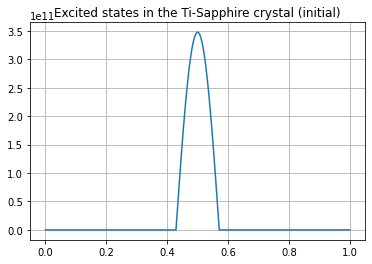

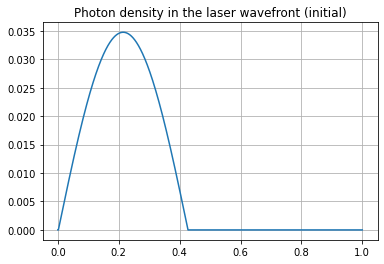


*******************************************
 Calling solver  904  times --


Mon Dec 28 12:33:19 2020

frantz_nodvik_1d results:
  Python version: 3.7.2
  FEniCS version 2019.1.0
  Solve the time-dependent 1d Frantz-Nodvik equations.


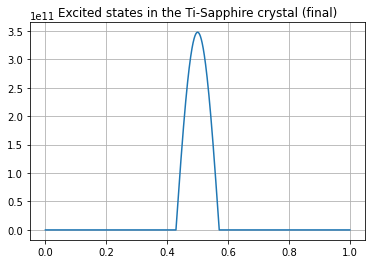

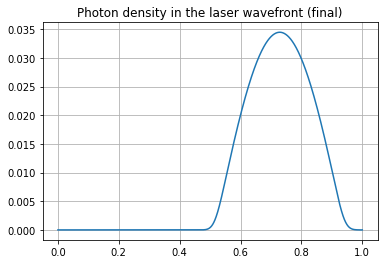


Mon Dec 28 12:33:20 2020


In [11]:
import dolfin
import platform
import time
import matplotlib.pyplot as plt

# uvals = fn1d.u.vector()
# mesh_pts = fn1d.mesh.coordinates()
# xvals = mesh_pts[:]
# print(' uvals = ', uvals[:])

# fn1d.n_steps = 1

uplot = project(fn1d.u, fn1d.v)
uplot_1, uplot_2 = split(uplot)

# initial plot of excited states and laser pulse envelope
plot(uplot_1, title=('Excited states in the Ti-Sapphire crystal (initial)'))
plt.grid(True)
plt.show()
plt.close()

plot(uplot_2, title=('Photon density in the laser wavefront (initial)'))
plt.grid(True)
plt.show()
plt.close()

# solve the equations for n_steps time steps
print('')
print('*******************************************')
print(' Calling solver ', fn1d.n_steps, ' times --')
print('')
print('')

for i_loop in range(0, fn1d.n_steps):
#    print('')
#    print('# of items in fn1d = ', len(fn1d))
    fn1d = frantz_nodvik_1d_solver(fn1d)

# uvals = fn1d.u.vector()
# print('')
# print(' uvals = ', uvals)

print(time.ctime(time.time()))
print('')
print('frantz_nodvik_1d results:')
print('  Python version: %s' % (platform.python_version()))
print('  FEniCS version %s'% (dolfin.__version__))
print('  Solve the time-dependent 1d Frantz-Nodvik equations.' )

uplot = project(fn1d.u, fn1d.v)
uplot_1, uplot_2 = split(uplot)

# final plot of excited states and laser pulse envelope
plot(uplot_1, title=('Excited states in the Ti-Sapphire crystal (final)'))
plt.grid(True)
plt.show()
plt.close()

plot(uplot_2, title=('Photon density in the laser wavefront (final)'))
plt.grid(True)
plt.show()
plt.close()

# wrap up
print('')
print(time.ctime(time.time()))